Here we will create and train a **U-Net** Neural network to segment text from the background. Network architecture and some utility functions are presented in the **unet.py** file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
from unet import unet
import unet_lines
import unet_words

In [ ]:
image_list=os.listdir('/content/drive/MyDrive/PageSegData/PageImg/') #  Insert your own path to training data
image_list=[filename.split(".")[0]for filename in image_list]

Defining model. If training is already done - proceed to loading weights.

In [ ]:
model_lines=unet()
model_lines.summary()

Train-test split.

In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

Training.

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('weights{epoch:08d}.h5', 
                                     save_weights_only=True, save_freq='epoch')
model_lines.fit_generator(unet_lines.batch_generator(file_train,2,2),epochs=3,steps_per_epoch=1000,validation_data=unet_lines.batch_generator(file_test,2,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)

<ipython-input-6-f5af798bf730>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(batch_generator(file_train,2,2),epochs=3,steps_per_epoch=1000,validation_data=batch_generator(file_test,2,2),


Epoch 1/3
1000/1000 [==============================] - 1087s 1s/step - loss: 0.5557 - accuracy: 0.6532 - val_loss: 0.3360 - val_accuracy: 0.9269
Epoch 2/3
1000/1000 [==============================] - 668s 668ms/step - loss: 0.3441 - accuracy: 0.9246 - val_loss: 0.3088 - val_accuracy: 0.9342
Epoch 3/3
1000/1000 [==============================] - 667s 667ms/step - loss: 0.3197 - accuracy: 0.9282 - val_loss: 0.2873 - val_accuracy: 0.9368


If you've already done this process, you can load pretrained weights into model here:

In [ ]:
# Insert your path to weights file
model_lines = unet(pretrained_weights='/content/drive/MyDrive/PageSegData/unet_lines.h5')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Splitting the text by the lines.

In [ ]:
line_img_array=[]


def segment_into_lines(filename):
    #Loading the image and performing thresholding on it and then resizing.
    img=cv2.imread(f'{filename}',0)
    ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
    img=cv2.resize(img,(512,512))
    #Expanding the dimension to account for the batch dimension.
    img= np.expand_dims(img,axis=-1)
    #Expanding dimension along channel axis.
    img=np.expand_dims(img,axis=0)
    #Predict the segmentation mask.
    pred=model_lines.predict(img)
    #Remove the batch and channel dimension for performing the binarization.
    pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)

    
    #Performing the binarization of the predicted mask for contour detection.
    coordinates=[]
    img = cv2.normalize(src=pred, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
    #Opening the original image to get the original dimension information.
    ori_img=cv2.imread(f'{filename}',0)
 

    (H, W) = ori_img.shape[:2]
    (newW, newH) = (512, 512)
    rW = W / float(newW)
    rH = H / float(newH)
    
    #Contour detection and bouding box generation.
    contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        #cv2.rectangle(ori_img, (int(x*rW), int(y*rH)), (int((x+w)*rW),int((y+h)*rH)), (255,0,0), 1)
        coordinates.append((int(x*rW),int(y*rH),int((x+w)*rW),int((y+h)*rH)))
    
   
    #Cropping the lines from the original image using the bouding boxes generated above.
    for i in range(len(coordinates)-1,-1,-1):
        coors=coordinates[i]

        p_img=ori_img[coors[1]:coors[3],coors[0]:coors[2]].copy()
        line_img_array.append(p_img)
        
    return line_img_array

Here we need to train another unet to split lines into words.

In [ ]:
image_list=os.listdir('/content/drive/MyDrive/Dataset_words/img/')
image_list=[filename.split(".")[0]for filename in image_list]

Train-test split.

In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

Defining model.

In [ ]:
model_words = unet()
model_words.summary()

Training.

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('weights{epoch:08d}.h5', 
                                     save_weights_only=True, save_freq='epoch')
model_words.fit_generator(unet_words.batch_generator(file_train,2,2),epochs=5,steps_per_epoch=1000,validation_data=unet_words.batch_generator(file_test,2,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)

You can insert weights of pre-trained model here.

In [ ]:
# Insert your path to weights file
model_words = unet(pretrained_weights='/content/drive/MyDrive/PageSegData/unet_words.h5')

Test words segmentation model.

1/1 [==============================] - 0s 18ms/step


True

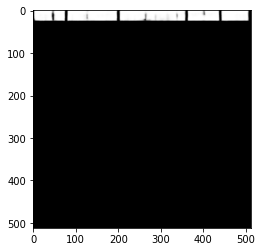

In [ ]:
file_test='/content/565468.jpg'
img=cv2.imread(f'{file_test}',0)
img=unet_words.pad_img(img)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img=np.expand_dims(img,axis=-1)
#img = np.stack((img,)*3, axis=-1)
img=img/255

img=np.expand_dims(img,axis=0)
pred=model_words.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

plt.imsave('test_img_mask.jpg',pred)


img = cv2.imread('/content/test_img_mask.jpg',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread(f'{file_test}',0)
ori_img=unet_words.pad_img(ori_img)
(H, W) = ori_img.shape[:2]
(newW, newH) = (512, 512)
rW = W / float(newW)
rH = H / float(newH)
ori_img_copy=np.stack((ori_img,)*3, axis=-1)

contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(ori_img_copy, (int(x*rW), int(y*rH)), (int((x+w)*rW),int((y+h)*rH)), (255,0,0), 1)
    #coordinates.append([x,y,(x+w),(y+h)])

cv2.imwrite("output.png",ori_img_copy)

Training a CRNN network to recognize Russian language.

In [1]:
import fnmatch
import cv2
import numpy as np
import string
import time

from keras_preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle

In [4]:
char_list = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789'
#CRNN model
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
crnn_model = Model(inputs, outputs)

In [5]:
crnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 32, 256)        2951

In [6]:
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

def find_dominant_color(image):
        #Resizing parameters
        width, height = 150,150
        image = image.resize((width, height),resample = 0)
        #Get colors from image object
        pixels = image.getcolors(width * height)
        #Sort them by count number(first element of tuple)
        sorted_pixels = sorted(pixels, key=lambda t: t[0])
        #Get the most frequent color
        dominant_color = sorted_pixels[-1][1]
        return dominant_color

def preprocess_img(img, imgSize):
    "put img into target img of size imgSize and normalize gray-values"

    # In case of black images with no text just use black image instead.
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]]) 
        print("Image None!")

    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1),
               max(min(ht, int(h / f)), 1))  # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize, interpolation=cv2.INTER_CUBIC) 
    most_freq_pixel=find_dominant_color(Image.fromarray(img))
    target = np.ones([ht, wt]) * most_freq_pixel  
    target[0:newSize[1], 0:newSize[0]] = img

    img = target

    return img

Generate data for training.

In [9]:
%cd data_generator
!python generate_data.py --n_samples 300000 --word_type uppercase

Preparing for training.

In [10]:
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0

annot=open('/content/annotation.txt','r').readlines()
imagenames=[]
txts=[]

for cnt in annot:
    filename,txt=cnt.split(',')[0],cnt.split(',')[1].split('\n')[0]
    imagenames.append(filename)
    txts.append(txt)
    
c = list(zip(imagenames, txts))

random.shuffle(c)

imagenames, txts = zip(*c)
    

    
for i in range(len(imagenames)):
        img = cv2.imread('/content/images/'+imagenames[i],0)   
 
        img=preprocess_img(img,(128,32))
        img=np.expand_dims(img,axis=-1)
        img = img/255.
        txt = txts[i]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        # split the 150000 data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        
        # break the loop if total data is 150000
        if i == 150000:
            flag = 1
            break
        i+=1

In [11]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [12]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    #Defining the CTC loss.
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
#CTC layer declaration using lambda.
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#Including the CTC layer to train the model.
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [13]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="/content/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [14]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [15]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Training.

In [16]:
batch_size = 256
epochs = 15
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length],
          y=np.zeros(len(training_img)), 
          batch_size=batch_size, epochs = epochs, 
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
          [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/15
528/528 [==============================] - ETA: 0s - loss: 21.4242
Epoch 1: val_loss improved from inf to 55.48057, saving model to /content/best_model.hdf5
528/528 [==============================] - 199s 340ms/step - loss: 21.4242 - val_loss: 55.4806
Epoch 2/15
528/528 [==============================] - ETA: 0s - loss: 0.5960
Epoch 2: val_loss improved from 55.48057 to 0.47057, saving model to /content/best_model.hdf5
528/528 [==============================] - 167s 316ms/step - loss: 0.5960 - val_loss: 0.4706
Epoch 3/15
528/528 [==============================] - ETA: 0s - loss: 0.2612
Epoch 3: val_loss did not improve from 0.47057
528/528 [==============================] - 167s 316ms/step - loss: 0.2612 - val_loss: 0.5703
Epoch 4/15
528/528 [==============================] - ETA: 0s - loss: 0.1824
Epoch 4: val_loss did not improve from 0.47057
528/528 [==============================] - 168s 317ms/step - loss: 0.1824 - val_loss: 0.7184
Epoch 5/15
528/528 [===================